In [1]:
import cPickle as pickle
import numpy as np
import time
%matplotlib notebook

import matplotlib.pyplot as plt
from IPython.display import clear_output


In [5]:
filename = 'models/vl_0518110412_200000'
with open(filename, 'r') as f:
    v1 = pickle.load(f)
    v2 = pickle.load(f)

vl1 = [np.zeros(4) for i in range(39)] # row score, init by 0
vl2 = [np.zeros(4) for i in range(14)] # box score, init by 0
filename = 'C_impl/model'
with open(filename, 'r') as f:
    with open(filename, 'r') as f:
        for i in range(39):
            for j in range(4):
                vl1[i][j] = np.fromfile(f, dtype=np.double, count=1)
        for i in range(14):
            for j in range(4):
                vl2[i][j] = np.fromfile(f, dtype=np.double, count=1)


In [6]:
def row2rank(v):
    n = len(v)
    r = [0 for i in range(len(v))]
    for i in range(n):
        for j in range(n):
            if v[j] < v[i]:
                r[i] = r[i] + 1
    return r

def grouping_idens(rs, idens):
    n = len(rs)
    c = [0]*n
    eqv_classes = []
    for i in range(n):
        if c[i] == 1:
            continue
        eqv_class = [rs[i]]
        for j in range(i+1, n):
            for trans in idens:
                if [rs[i][trans[k]] for k in range(4)] == rs[j]:
                    eqv_class.append(rs[j])
                    c[j] = 1
                    break
        eqv_classes.append(eqv_class)
    rank2idx = [0 for i in range(4*4*4*4)]
    for idx, eqv_class in enumerate(eqv_classes):
        for rank in eqv_class:
            rank2idx[rank[0]*4*4*4 + rank[1]*4*4 + rank[2]*4 + rank[3]] = idx
    return eqv_classes, rank2idx

rs = []
v = [0, 0, 0, 0]
while True:
    r = row2rank(v)
    flag = True
    for old_r in rs:
        if old_r == r:
            flag = False
            break
    if flag: rs.append(r)
    i = 3
    while i >= 0:
        v[i] = v[i] + 1
        if v[i] == 4:
            v[i] = 0
            i = i - 1
        else:
            break
    if v == [0,0,0,0]:
        break
row_eqv, rank2idx_row = grouping_idens(rs, [[0,1,2,3],[3,2,1,0]])
box_eqv, rank2idx_box = grouping_idens(rs, [[0,1,2,3],[2,0,3,1],[3,2,1,0],[1,3,0,2],[1,0,3,2],[3,1,2,0],[2,3,0,1],[0,2,1,3]])

In [10]:
def original_row2idx(row):
    idx = []
    idx.append(row[0] * 18 * 18 * 18 + row[1] * 18 * 18 + row[2] * 18 + row[3])
    idx.append(row[3] * 18 * 18 * 18 + row[2] * 18 * 18 + row[1] * 18 + row[0])
    return min(idx)

def original_box2idx(row):
    idx = []
    # 0 1   2 0    3 2  1 3
    # 2 3   3 1    1 0  0 2
    idx.append(row[0] * 18 * 18 * 18 + row[1] * 18 * 18 + row[2] * 18 + row[3])
    idx.append(row[2] * 18 * 18 * 18 + row[0] * 18 * 18 + row[3] * 18 + row[1])
    idx.append(row[3] * 18 * 18 * 18 + row[2] * 18 * 18 + row[1] * 18 + row[0])
    idx.append(row[1] * 18 * 18 * 18 + row[3] * 18 * 18 + row[0] * 18 + row[2])
    return min(idx)

def meandiff_x(row):
    row_mean = np.mean([2**r for r in row]) # 0 as 1 for simplicity
    return np.log2(row_mean) / 10., (max(row)-min(row))

def row2idx(row):
    rank = row2rank(row)
    x, d = meandiff_x(row)
    return (rank2idx_row[rank[0]*4*4*4 + rank[1]*4*4 + rank[2]*4 + rank[3]], x, d)

def box2idx(row):
    rank = row2rank(row)
    x, d = meandiff_x(row)
    return (rank2idx_box[rank[0]*4*4*4 + rank[1]*4*4 + rank[2]*4 + rank[3]], x, d)

maxv = 12
v = [0, 0, 0, 0]
rows_x = [[] for i in range(39)]
rows_y = [[] for i in range(39)]
rows_c = [[] for i in range(39)]
boxs_x = [[] for i in range(14)]
boxs_y = [[] for i in range(14)]
boxs_c = [[] for i in range(14)]
while True:
    # row
    original_idx = original_row2idx(v)
    y = v1[original_idx]
    idx, x, d = row2idx(v)
    rows_x[idx].append(x)
    rows_y[idx].append(y)
    rows_c[idx].append(d*10./maxv)
    
    original_idx = original_box2idx(v)
    y = v2[original_idx]
    idx, x, d = box2idx(v)
    boxs_x[idx].append(x)
    boxs_y[idx].append(y)
    boxs_c[idx].append(d*10./maxv)
    
    i = 3
    while i >= 0:
        v[i] = v[i] + 1
        if v[i] == maxv:
            v[i] = 0
            i = i - 1
        else:
            break
    if v == [0,0,0,0]:
        break


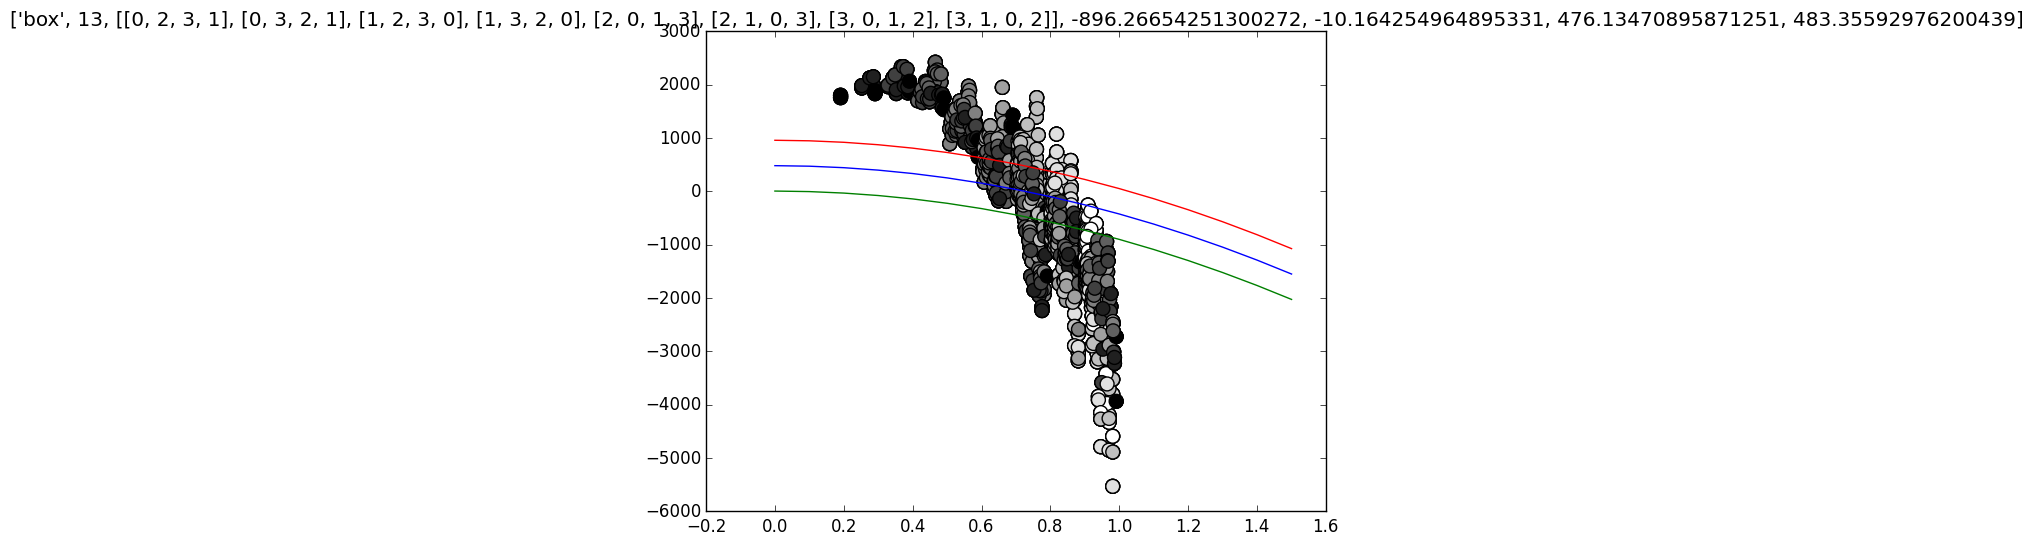

In [12]:
from IPython import display

for idx in range(39):
    plt.clf()
    plt.scatter(rows_x[idx], rows_y[idx], 100, rows_c[idx])
    
    a, b, c, d = vl1[idx]
    x = np.arange(0, 1.6, 0.1);
    y = a*x*x + b*x + d
    plt.plot(x, y)
    x = np.arange(0, 1.6, 0.1);
    y = a*x*x + b*x + d - c
    plt.plot(x, y)
    x = np.arange(0, 1.6, 0.1);
    y = a*x*x + b*x + d + c
    plt.plot(x, y)
    plt.gray()
    plt.title(['row',idx,row_eqv[idx],a,b,c,d])
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)

for idx in range(14):
    plt.clf()
    plt.scatter(boxs_x[idx], boxs_y[idx], 100, boxs_c[idx])
    
    a, b, c, d = vl2[idx]
    x = np.arange(0, 1.6, 0.1);
    y = a*x*x + b*x + d
    plt.plot(x, y)
    x = np.arange(0, 1.6, 0.1);
    y = a*x*x + b*x + d - c
    plt.plot(x, y)
    x = np.arange(0, 1.6, 0.1);
    y = a*x*x + b*x + d + c
    plt.plot(x, y)
    plt.gray()
    plt.title(['box',idx,box_eqv[idx],a,b,c,d])
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)